<font size='8'>Salary Prediction</font>

<font size='6' color='lightblue'>Linear Regression</font>

<font size='6'>Data Cleaning</font>

In [424]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso, 
    ElasticNet,
    SGDRegressor,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mse


pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

<font size='4'>Read data</font>

In [425]:
FILE_NAME = "Salary_Data.csv"
df = pd.read_csv(FILE_NAME, delimiter=',')
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


<font size='4'>Save a copy data</font>

In [426]:
df_raw = df
df_raw

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


<font size='6'>Data Cleaning</font>

<font size='4'>Rename columns</font>

In [427]:
print(df.columns)
def cleaning_rename_cols(df) -> pd.DataFrame:
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]
    print('rename column - Successful ...')
    return df

df = cleaning_rename_cols(df)
print(df.columns)

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
rename column - Successful ...
Index(['age', 'gender', 'education_level', 'job_title', 'years_of_experience',
       'salary'],
      dtype='object')


<font size='4'>Check columns values</font>

In [428]:
for col in df.columns:
    # print(f"{col}:\n{df[col].info()}", end='\n\n')
    print(f"{col}:\n"
          f"null: {df[col].isnull().any()}\n"
          f"NaN:  {df[col].isna().any()}", end='\n\n')

age:
null: True
NaN:  True

gender:
null: True
NaN:  True

education_level:
null: True
NaN:  True

job_title:
null: True
NaN:  True

years_of_experience:
null: True
NaN:  True

salary:
null: True
NaN:  True



<font size='3'>remove Target column missing value rows</font>

In [429]:
# df = df.dropna(subset=['salary']).reset_index()          # create index column, keep all index
def cleaning_nan_salary(df):
    return df.dropna(subset=['salary']).reset_index(drop=True)

df = cleaning_nan_salary(df)
print(df['salary'].isna().any())
print(df['salary'].isnull().any())


False
False


<font size='3'>check Target column outliner, and address it</font>

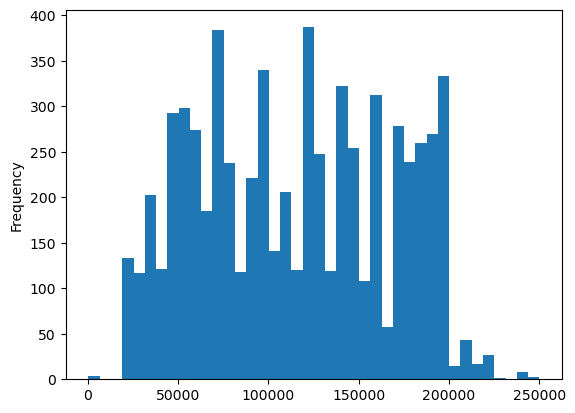

In [430]:
# plt.hist(df['salary'], bins=32)
# sns.violinplot(x=df['salary'])
df['salary'].plot(kind='hist', bins=40)
plt.show()

<font size='3'>check minimum, remove unreasonable data</font>

In [431]:
print(df.sort_values(by=['salary']).head(10), end='\n\n')

def cleaning_remove_salary_outlier(df, lower_bound=10000):
    df['salary'] = df['salary'].astype('int32')
    df = df[df['salary'] > lower_bound]
    return df


df = cleaning_remove_salary_outlier(df)
print(df.sort_values(by=['salary']).head(10))
df.info()

       age  gender    education_level                           job_title  years_of_experience   salary
258   29.0    Male         Bachelor's  Junior Business Operations Analyst                  1.5    350.0
4630  31.0  Female  Bachelor's Degree               Junior HR Coordinator                  4.0    500.0
1888  25.0  Female  Bachelor's Degree                 Front end Developer                  1.0    550.0
2652  23.0    Male                PhD           Software Engineer Manager                  1.0    579.0
4920  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4933  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4946  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4959  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4972  21.0  Female        High School         Junior Sales Repre

<font size='3'>check maximum, remove unreasonable data</font>

In [432]:
print(df.sort_values(by=['salary']).tail(10), end='\n\n')

# def remove_outlier_upper(df, col, upper_bound=10000):
#     return df[df[col] < upper_bound]


# df = remove_outlier_lower(df, 'salary')
# print(df.sort_values(by=['salary']).tail(10))

       age gender    education_level                 job_title  years_of_experience  salary
4288  51.0   Male                PhD            Data Scientist                 24.0  240000
4378  51.0   Male                PhD            Data Scientist                 24.0  240000
4348  51.0   Male                PhD            Data Scientist                 24.0  240000
4303  51.0   Male                PhD            Data Scientist                 24.0  240000
4363  51.0   Male                PhD            Data Scientist                 24.0  240000
4333  51.0   Male                PhD            Data Scientist                 24.0  240000
4273  51.0   Male                PhD            Data Scientist                 24.0  240000
4998  45.0   Male  Bachelor's Degree         Financial Manager                 21.0  250000
30    50.0   Male         Bachelor's                       CEO                 25.0  250000
83    52.0   Male                PhD  Chief Technology Officer                 2

In [433]:
def cleaning_salary(df):
    cleaning_nan_salary(df)
    print("cleaning nan salary - Successful ...")
    cleaning_remove_salary_outlier(df)
    # cleaning_remove_salary_outlier_upper(df)
    print("cleaning salary outlier - Successful ...")

cleaning_salary(df)
df

cleaning nan salary - Successful ...
cleaning salary outlier - Successful ...


,age,gender,education_level,job_title,years_of_experience,salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000
1,28.0,Female,Master's,Data Analyst,3.0,65000
2,45.0,Male,PhD,Senior Manager,15.0,150000
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000
4,52.0,Male,Master's,Director,20.0,200000
...,...,...,...,...,...,...
6694,49.0,Female,PhD,Director of Marketing,20.0,200000
6695,32.0,Male,High School,Sales Associate,3.0,50000
6696,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000
6697,46.0,Male,Master's Degree,Marketing Manager,14.0,140000


In [434]:
# def remove_outlier(df, col, t_fac=2.5):
#     ## version 1
#     # mean_ = df[col].mean()
#     # std_ = df[col].std()
#     # upper_bound = mean_ + t_fac * std_
#     # lower_bound = mean_ - t_fac * std_


#     ## version 2
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     IQR = t_fac * (q3 - q1)
#     upper_bound, lower_bound = q3 + IQR, q1 - IQR

#     return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# df = remove_outlier(df, 'salary', t_fac=0.7)

# df['salary'].plot(kind='hist', bins=40)
# plt.show()

<font size='4'>Check again columns values</font>

In [435]:
for col in df.columns:
    print(f"{col}:\n"
          f"null: {df[col].isnull().any()}\n"
          f"NaN: {df[col].isna().any()}", end='\n\n')

age:
null: False
NaN: False

gender:
null: False
NaN: False

education_level:
null: True
NaN: True

job_title:
null: False
NaN: False

years_of_experience:
null: False
NaN: False

salary:
null: False
NaN: False



<font size='4'>Check each feature(column)</font>

<font size='3'>feature: age</font>

In [436]:
df['age'].unique() # no NaN

def cleaning_age(df):
    df.loc[:, 'age'] = df['age'].astype('int32')
    print('cleaning age - Successful ...')

cleaning_age(df)
df['age'].unique()

cleaning age - Successful ...


array([32., 28., 45., 36., 52., 29., 42., 31., 26., 38., 48., 35., 40.,
       27., 44., 33., 39., 25., 51., 34., 47., 30., 41., 37., 24., 43.,
       50., 46., 49., 23., 53., 61., 57., 62., 55., 56., 54., 60., 58.,
       22., 21.])

<font size='3'>feature: gender</font>

In [437]:
df['gender'].unique() # no NaN


def cleaning_gender(df):
    mapping = {'Male': 'male', 'Female': 'female', 'Other': 'other'}
    df.loc[:, 'gender'] = df['gender'].map(mapping).fillna(df['gender'])
    print('cleaning gender - Successful ...')

cleaning_gender(df)
df['gender'].unique()

cleaning gender - Successful ...


array(['male', 'female', 'other'], dtype=object)

<font size='3'>feature: education_level</font>

In [438]:
df['education_level'].unique()

def cleaning_edu(df):
    el_str = df['education_level'].str.lower()
    df.loc[:, 'education_level'] = np.select(
        condlist=[
            el_str.str.contains('bachelor', na=False),
            el_str.str.contains('master', na=False),
            el_str.str.contains('phd', na=False),
            el_str.str.contains('high school', na=False),
        ],
        choicelist=[
            'Bachelor',
            'Master',
            'PhD',
            'High School'
        ],
        default='No Specified',
    ).astype('str')
    print('cleaning education level - Successful ...')


cleaning_edu(df)
df['education_level'].unique()

cleaning education level - Successful ...


array(['Bachelor', 'Master', 'PhD', 'No Specified', 'High School'],
      dtype=object)

<font size='3'>feature: job_title</font>

In [439]:
df['job_title'].unique()

def cleaning_job(df):
    df.loc[:, 'job_title'] = (
        df['job_title']
        # .str
        # .replace(r'\b(Junior|Juniour|Senior)\b\s+', '', regex=True)
        .str.strip()
        .astype('str')
    )
    print('cleaning job title - Successful ...')

cleaning_job(df)
df['job_title'].unique()

cleaning job title - Successful ...


array(['Software Engineer', 'Data Analyst', 'Senior Manager',
       'Sales Associate', 'Director', 'Marketing Analyst',
       'Product Manager', 'Sales Manager', 'Marketing Coordinator',
       'Senior Scientist', 'Software Developer', 'HR Manager',
       'Financial Analyst', 'Project Manager', 'Customer Service Rep',
       'Operations Manager', 'Marketing Manager', 'Senior Engineer',
       'Data Entry Clerk', 'Sales Director', 'Business Analyst',
       'VP of Operations', 'IT Support', 'Recruiter', 'Financial Manager',
       'Social Media Specialist', 'Software Manager', 'Junior Developer',
       'Senior Consultant', 'Product Designer', 'CEO', 'Accountant',
       'Data Scientist', 'Marketing Specialist', 'Technical Writer',
       'HR Generalist', 'Project Engineer', 'Customer Success Rep',
       'Sales Executive', 'UX Designer', 'Operations Director',
       'Network Engineer', 'Administrative Assistant',
       'Strategy Consultant', 'Copywriter', 'Account Manager',
      

<font size='3'>feature: years_of_experience</font>

In [440]:
df['years_of_experience'].unique()

def cleaning_exp(df):
    df.loc[:, 'years_of_experience'] = df['years_of_experience'].astype('float32')
    print('cleaning years of experience - Successful ...')

cleaning_exp(df)
df['years_of_experience'].unique()

cleaning years of experience - Successful ...


array([ 5. ,  3. , 15. ,  7. , 20. ,  2. , 12. ,  4. ,  1. , 10. , 18. ,
        6. , 14. , 16. ,  0. , 22. , 19. ,  9. , 13. , 11. , 25. , 21. ,
        8. , 17. , 23. , 24. ,  0.5,  1.5, 31. , 30. , 28. , 33. , 27. ,
       34. , 29. , 26. , 32. ])

In [441]:
def data_cleaning(df, has_target=False):
    cleaning_rename_cols(df)
    if has_target:
        cleaning_salary(df)
    cleaning_age(df)
    cleaning_gender(df)
    cleaning_edu(df)
    cleaning_job(df)
    cleaning_exp(df)

    print("... Finishing Cleaning Process ...")

data_cleaning(df, has_target=True)
df

rename column - Successful ...
cleaning nan salary - Successful ...
cleaning salary outlier - Successful ...
cleaning age - Successful ...
cleaning gender - Successful ...
cleaning education level - Successful ...
cleaning job title - Successful ...
cleaning years of experience - Successful ...
... Finishing Cleaning Process ...


,age,gender,education_level,job_title,years_of_experience,salary
0,32.0,male,Bachelor,Software Engineer,5.0,90000
1,28.0,female,Master,Data Analyst,3.0,65000
2,45.0,male,PhD,Senior Manager,15.0,150000
3,36.0,female,Bachelor,Sales Associate,7.0,60000
4,52.0,male,Master,Director,20.0,200000
...,...,...,...,...,...,...
6694,49.0,female,PhD,Director of Marketing,20.0,200000
6695,32.0,male,High School,Sales Associate,3.0,50000
6696,30.0,female,Bachelor,Financial Manager,4.0,55000
6697,46.0,male,Master,Marketing Manager,14.0,140000


<font size='6'>Data Visualization</font>

In [442]:
df

,age,gender,education_level,job_title,years_of_experience,salary
0,32.0,male,Bachelor,Software Engineer,5.0,90000
1,28.0,female,Master,Data Analyst,3.0,65000
2,45.0,male,PhD,Senior Manager,15.0,150000
3,36.0,female,Bachelor,Sales Associate,7.0,60000
4,52.0,male,Master,Director,20.0,200000
...,...,...,...,...,...,...
6694,49.0,female,PhD,Director of Marketing,20.0,200000
6695,32.0,male,High School,Sales Associate,3.0,50000
6696,30.0,female,Bachelor,Financial Manager,4.0,55000
6697,46.0,male,Master,Marketing Manager,14.0,140000


In [443]:
gen_ord = ['female', 'male', 'other']
df['gender'] = pd.Categorical(df['gender'], categories=gen_ord, ordered=True)

edu_ord = ['No Specified', 'High School', 'Bachelor', 'Master', 'PhD']
df['education_level'] = pd.Categorical(df['education_level'], categories=edu_ord, ordered=True)

## set save images file
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)

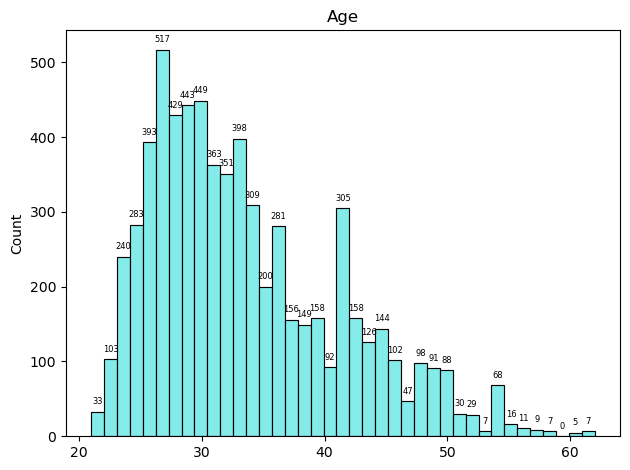

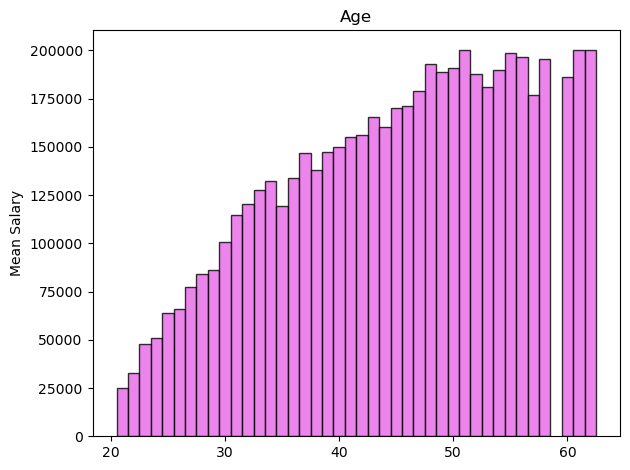

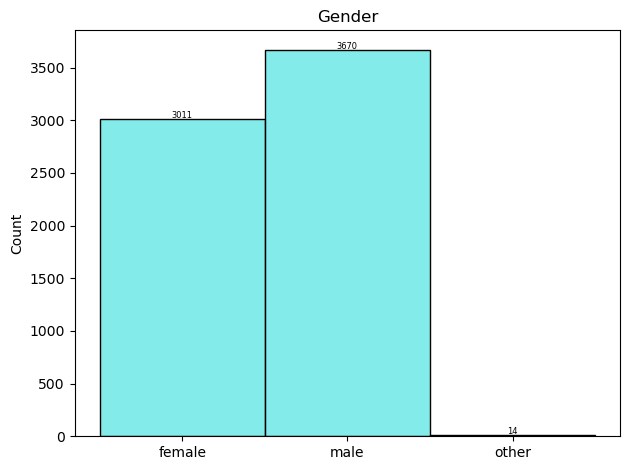

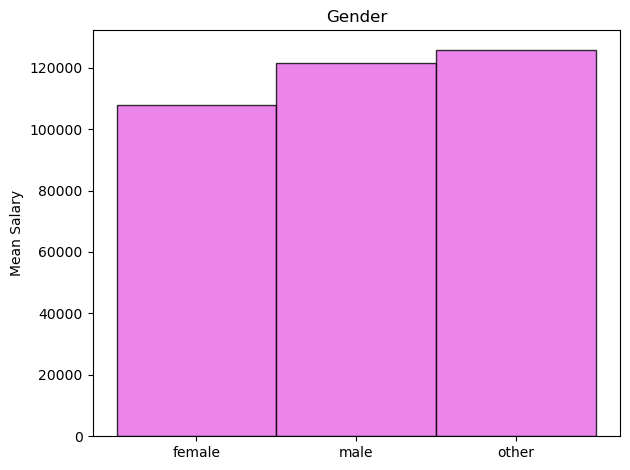

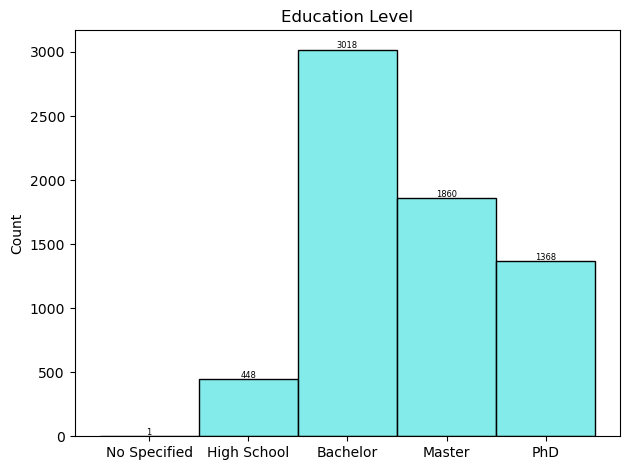

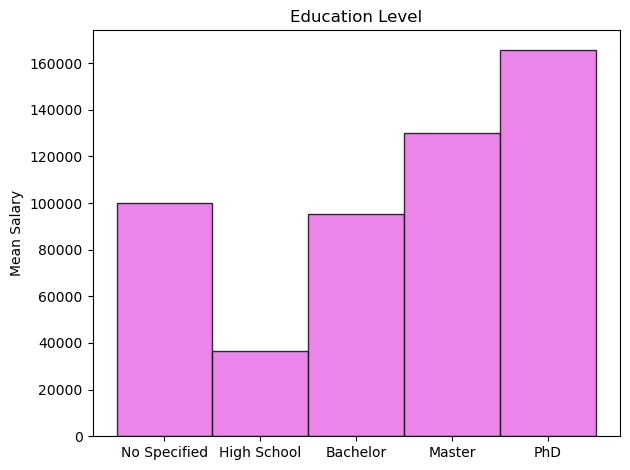

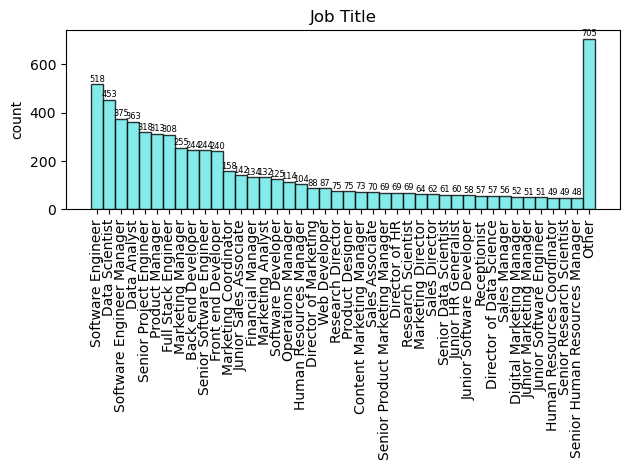

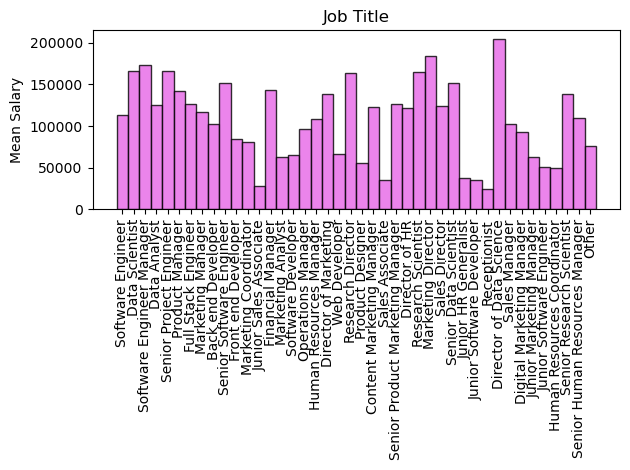

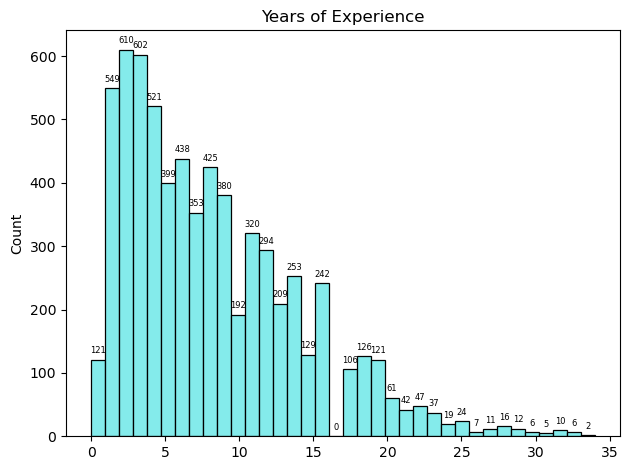

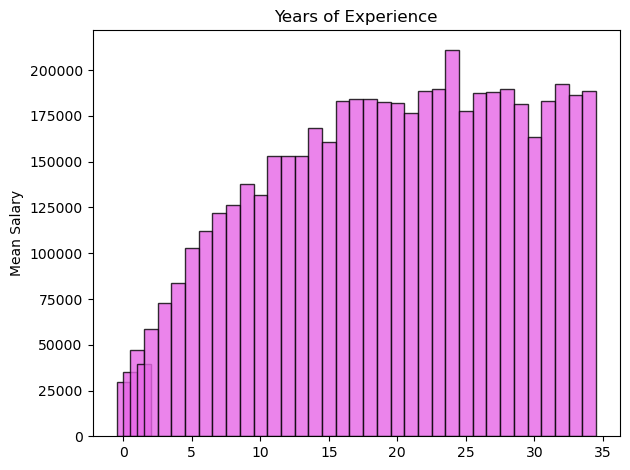

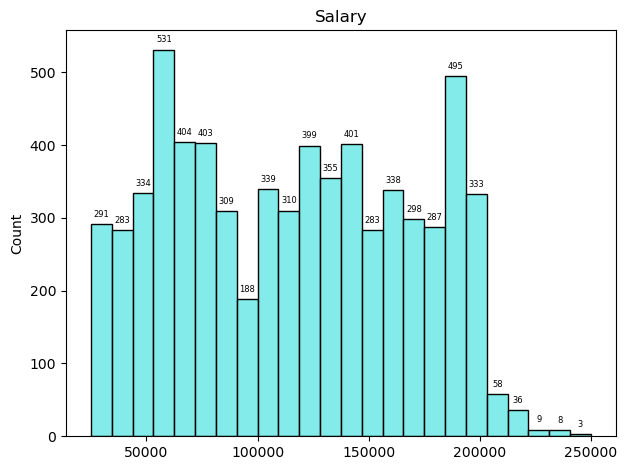

In [444]:
def show_plot(df, col):
    title_ = col

    ## show distribution
    if col == 'job_title':
        plt.xticks(rotation=90)

        threshold = 45
        agg_job = df[col].value_counts()
        valid_job = agg_job[agg_job > threshold]
        valid_job.loc['Other'] = agg_job[agg_job <= threshold].sum()

        bars = sns.barplot(data=valid_job,
                           color=(0.4, 0.9, 0.9),
                           edgecolor='black',
                           saturation=1,
                           alpha=0.8,
                           width=1)
        bars.margins(x=0.05)

    else :
        bars = sns.histplot(data=df,
                            x=col,
                            color=(0.4, 0.9, 0.9),
                            alpha=0.8)

    for bar in bars.patches:
        bbox = bar.get_bbox()
        x0 = bbox.x0
        width = bbox.width
        height = bbox.y1 - bbox.y0
        x_position = x0 + width / 2
        bars.text(x=x_position, y=height + 10,
                  s=f"{int(height)}",
                  ha='center',
                  fontsize=6)

    if '_' not in title_:
        title_ = title_[0].upper() + title_[1:]
    else :
        title_ = " ".join([n_split.capitalize()
                           if n_split != 'of'
                           else n_split
                           for n_split in title_.split('_')])

    plt.xlabel('')
    plt.title(title_)
    plt.tight_layout()

    ## save image
    fig_fname = f'{col}_distribution.png'
    plt.savefig(os.path.join(images_dir, fig_fname), bbox_inches='tight')

    ## plot image
    plt.show()

    if col == 'salary':
        return

    ## show relation with target feature
    d = df.groupby([col], observed=False)['salary'].mean()

    if col == 'job_title':
        plt.xticks(rotation=90)
        # threshold = 70
        agg_job = df[col].value_counts()
        valid_job_index = agg_job[agg_job > threshold].index

        temp_ = df[[col, 'salary']].copy()
        temp_[col] = temp_[col].where(temp_[col].isin(valid_job_index), other='Other')
        d = temp_.groupby([col])['salary'].mean()
        valid_job_index = list(valid_job_index) + ['Other']
        d = d.reindex(valid_job_index)

    plt.bar(d.index, d.values, width=1, color=(0.9, 0.4, 0.9),
            edgecolor='black', alpha=0.8)

    plt.xlabel('')
    plt.ylabel('Mean Salary')
    plt.title(title_)
    plt.tight_layout()

    ## save image
    fig_fname = f'{col}_salary_relation.png'
    plt.savefig(os.path.join(images_dir, fig_fname), bbox_inches='tight')

    ## plot image
    plt.show()




for col in df.columns:
    show_plot(df, col)

In [445]:
df_cleaned = df.copy()
df_cleaned

,age,gender,education_level,job_title,years_of_experience,salary
0,32.0,male,Bachelor,Software Engineer,5.0,90000
1,28.0,female,Master,Data Analyst,3.0,65000
2,45.0,male,PhD,Senior Manager,15.0,150000
3,36.0,female,Bachelor,Sales Associate,7.0,60000
4,52.0,male,Master,Director,20.0,200000
...,...,...,...,...,...,...
6694,49.0,female,PhD,Director of Marketing,20.0,200000
6695,32.0,male,High School,Sales Associate,3.0,50000
6696,30.0,female,Bachelor,Financial Manager,4.0,55000
6697,46.0,male,Master,Marketing Manager,14.0,140000


<font size='6'>Data Spliting</font>

In [446]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## TODO: test using interactive column age*y_exp, and using polynomialfeature transformer
## TODO: imbalance? fit in pipeline? how to handle column name?

# X['age**2'] = X['age']**2
# X['age*y_exp'] = X['age'] * X['years_of_experience']
# X['y_exp**2'] = X['years_of_experience']**2

In [447]:
# train set size = 0.8
# test set size  = 0.2

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train
# y_train
X_test
# y_test

,age,gender,education_level,job_title,years_of_experience
6569,36.0,male,Bachelor,Sales Director,6.0
1515,54.0,male,PhD,Software Engineer Manager,17.0
6241,29.0,male,Bachelor,Marketing Analyst,4.0
5464,26.0,female,Bachelor,Social Media Manager,3.0
5318,28.0,male,Bachelor,Product Designer,3.0
...,...,...,...,...,...
4476,41.0,male,PhD,Data Scientist,15.0
6621,28.0,male,PhD,Marketing Manager,4.0
1037,25.0,female,Bachelor,Data Analyst,2.0
2010,31.0,female,Bachelor,Front end Developer,6.0


<font size='6'>Data Preprocessing</font>

In [ ]:
# onehot_encode_col = ['gender']
# ordinal_encode_col = ['education_level']
# target_encode_col = ['Job_Title']

ordinal_ord = ['No Specified', 'High School', 'Bachelor', 'Master', 'PhD']
poly_feature_col = ['age', 'years_of_experience', 'education_level', 'job_title']
# poly_feature_col = ['age', 'years_of_experience', 'education_level', 'job_title']
scaler_col = ['age', 'job_title', 'years_of_experience']

In [449]:
set_config(transform_output='pandas')

preprocessor = ColumnTransformer(
    transformers=[
        ('gen_encoder', OneHotEncoder(sparse_output=False), ['gender']),
        ('edu_encoder',
         OrdinalEncoder(categories=[ordinal_ord]), ['education_level']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

poly_step = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(include_bias=False), poly_feature_col)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

scaler_step = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaler_col)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

features_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('job_encode', TargetEncoder(cols=['job_title'])),
    ('poly', poly_step),
    ('scaler', scaler_step),
])

# model_pipeline = Pipeline([
#     ('feature', features_pipeline),
#     ('model', LinearRegression()),
# ])

# X_test

X_train_ = features_pipeline.fit_transform(X_train, y_train)
X_train_
X_test_ = features_pipeline.transform(X_test)
X_test_

,age,job_title,years_of_experience,education_level,age^2,age years_of_experience,age education_level,age job_title,years_of_experience^2,years_of_experience education_level,years_of_experience job_title,education_level^2,education_level job_title,job_title^2,gender_female,gender_male,gender_other
6569,0.303821,0.083906,-0.346411,2.0,1296.0,216.0,72.0,4.338213e+06,36.0,12.0,7.230355e+05,4.0,241011.839841,1.452168e+10,0.0,1.0,0.0
1515,2.651778,1.393586,1.451595,4.0,2916.0,918.0,216.0,9.320204e+06,289.0,68.0,2.934138e+06,16.0,690385.513158,2.978951e+10,0.0,1.0,0.0
6241,-0.609273,-1.357287,-0.673322,2.0,841.0,116.0,58.0,1.832358e+06,16.0,8.0,2.527390e+05,4.0,126369.511699,3.992313e+09,0.0,1.0,0.0
5464,-1.000600,-0.488397,-0.836777,2.0,676.0,78.0,52.0,2.541331e+06,9.0,6.0,2.932305e+05,4.0,195487.016697,9.553793e+09,1.0,0.0,0.0
5318,-0.739716,-1.508020,-0.836777,2.0,784.0,84.0,56.0,1.601309e+06,9.0,6.0,1.715688e+05,4.0,114379.196950,3.270650e+09,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476,0.956031,1.224235,1.124685,4.0,1681.0,615.0,164.0,6.800290e+06,225.0,60.0,2.487911e+06,16.0,663442.896936,2.750978e+10,0.0,1.0,0.0
6621,-0.739716,0.087862,-0.673322,4.0,784.0,112.0,112.0,3.378571e+06,16.0,16.0,4.826531e+05,16.0,482653.060721,1.455962e+10,0.0,1.0,0.0
1037,-1.131042,0.146082,-1.000232,2.0,625.0,50.0,50.0,3.074472e+06,4.0,4.0,2.459577e+05,4.0,245957.746479,1.512380e+10,1.0,0.0,0.0
2010,-0.348389,-0.804410,-0.346411,2.0,961.0,186.0,62.0,2.640412e+06,36.0,12.0,5.110475e+05,4.0,170349.166762,7.254710e+09,1.0,0.0,0.0


<font size='4'>Show heatmap in all features</font>

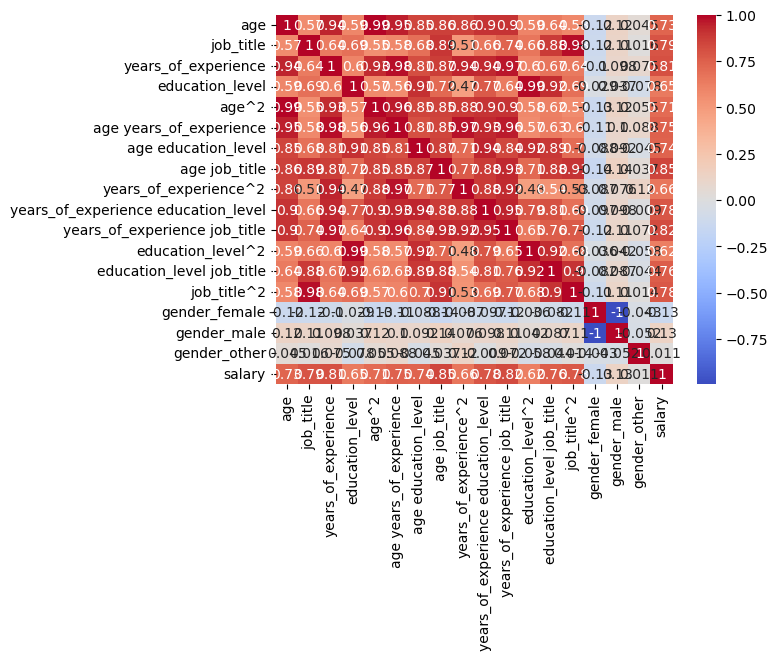

In [450]:
heatmap_df = X_train_.copy()
heatmap_df['salary'] = y_train
sns.heatmap(heatmap_df.corr(), annot=True, cmap='coolwarm')

## save fig
plt.savefig(os.path.join(images_dir, 'features_heatmap.png'),
            bbox_inches='tight')
## show fig
plt.show()

<font size='6'>Training</font>

In [451]:
X_train
X_train_
# y_train

,age,job_title,years_of_experience,education_level,age^2,age years_of_experience,age education_level,age job_title,years_of_experience^2,years_of_experience education_level,years_of_experience job_title,education_level^2,education_level job_title,job_title^2,gender_female,gender_male,gender_other
3861,-0.870158,-2.238004,-1.000232,1.0,729.0,54.0,27.0,7.602018e+05,4.0,2.0,5.631125e+04,1.0,28155.624001,7.927392e+08,0.0,1.0,0.0
4790,-0.478831,-1.220604,-0.673322,2.0,900.0,120.0,60.0,2.058634e+06,16.0,8.0,2.744845e+05,4.0,137242.252295,4.708859e+09,1.0,0.0,0.0
2742,1.869126,2.078278,1.615050,4.0,2304.0,864.0,192.0,9.591789e+06,324.0,72.0,3.596921e+06,16.0,799315.729751,3.993160e+10,0.0,1.0,0.0
191,-0.478831,-0.280851,-0.836777,2.0,900.0,90.0,60.0,3.179949e+06,9.0,6.0,3.179949e+05,4.0,211996.583451,1.123564e+10,1.0,0.0,0.0
2296,-0.478831,-0.127323,-0.509866,2.0,900.0,150.0,60.0,3.363139e+06,25.0,10.0,5.605231e+05,4.0,224209.245742,1.256745e+10,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,-0.478831,1.224235,-0.182956,4.0,900.0,210.0,120.0,4.975822e+06,49.0,28.0,1.161025e+06,16.0,663442.896936,2.750978e+10,1.0,0.0,0.0
3279,0.173379,0.146082,0.143954,3.0,1225.0,315.0,105.0,4.304261e+06,81.0,27.0,1.106810e+06,9.0,368936.619718,1.512380e+10,1.0,0.0,0.0
1319,-0.870158,-0.804410,-0.836777,2.0,729.0,81.0,54.0,2.299714e+06,9.0,6.0,2.555238e+05,4.0,170349.166762,7.254710e+09,0.0,1.0,0.0
724,-0.870158,-0.127323,-0.673322,2.0,729.0,108.0,54.0,3.026825e+06,16.0,8.0,4.484185e+05,4.0,224209.245742,1.256745e+10,0.0,1.0,0.0


<font size='4'>fit</font>

In [452]:
parm_space = {
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'alpha': Real(1e-5, 1e+1, prior='log-uniform'),
    'max_iter': Integer(1000, 5000, prior='uniform'),
    'tol': Real(1e-5, 1e-3, prior='log-uniform'),
    'l1_ratio': Real(0.1, 0.9, prior='uniform'),
    'learning_rate': Categorical(['adaptive', 'constant']),
    'eta0': Real(1e-3, 1, prior='log-uniform'),
}

common_paras = {
    'n_iter': 30,
    'cv': 5,
    'n_jobs': -1,
    # 'random_state': 34,
    'scoring': 'neg_mean_squared_error',
}

linear_model = BayesSearchCV(
    estimator=SGDRegressor(early_stopping=True),
    search_spaces=parm_space,
    **common_paras,
)

linear_model.fit(X_train_, y_train)
y_pred_ln = linear_model.predict(X_test_)

In [453]:
ln_df = X_test.copy()
ln_df['true_salary'] = y_test

ln_df[f'predict'] = y_pred_ln
ln_df[f'difference'] = ln_df['true_salary'] - ln_df[f'predict']

ln_df

,age,gender,education_level,job_title,years_of_experience,true_salary,predict,difference
6569,36.0,male,Bachelor,Sales Director,6.0,75000,-3.623461e+25,3.623461e+25
1515,54.0,male,PhD,Software Engineer Manager,17.0,195000,-7.323507e+25,7.323507e+25
6241,29.0,male,Bachelor,Marketing Analyst,4.0,75000,-9.645337e+24,9.645337e+24
5464,26.0,female,Bachelor,Social Media Manager,3.0,55000,-2.409446e+25,2.409446e+25
5318,28.0,male,Bachelor,Product Designer,3.0,60000,-7.880081e+24,7.880081e+24
...,...,...,...,...,...,...,...,...
4476,41.0,male,PhD,Data Scientist,15.0,157000,-6.857514e+25,6.857514e+25
6621,28.0,male,PhD,Marketing Manager,4.0,55000,-3.692341e+25,3.692341e+25
1037,25.0,female,Bachelor,Data Analyst,2.0,100000,-3.869919e+25,3.869919e+25
2010,31.0,female,Bachelor,Front end Developer,6.0,110000,-1.779885e+25,1.779885e+25


<font size='6'>Assess Model</font>

In [454]:
parm_dict = linear_model.best_params_
if parm_dict.get('penalty', '') != 'elasticnet':
    parm_dict.pop('l1_ratio', None)

print(f"Linear Model:")
for i, v in parm_dict.items():
    # print(type(i), type(v))
    if type(v) == float:
        print(f"    {i}: {v:.6f}")
    else :
        print(f"    {i}: {v}")

print(f"    mse: {mean_squared_error(y_test, y_pred_ln):.2f}")
print(f"    mae: {mean_absolute_error(y_test, y_pred_ln):.2f}")

Linear Model:
    alpha: 0.000017
    eta0: 0.006079
    learning_rate: adaptive
    max_iter: 1290
    penalty: l2
    tol: 0.000070
    mse: 1943131417658642773500116317755705828219228094726144.00
    mae: 38347867113077406917722112.00


<font size='6'>Predict</font>

Given an exmaple, we should predict it</br>
assume example has no NaN

In [142]:
df.columns.difference(['salary'], sort=False)

Index(['age', 'gender', 'education_level', 'job_title', 'years_of_experience'], dtype='object')

In [155]:
example_dataset = np.array([
    [26, 'Male', "Master", "Data Analyst", 0],
    [62, 'Male', "Master", "Data Analyst", 20],
    [32, 'Female', "Master", "Data Analyst", 10],
    [45, 'Other', "Bachelor", "Data Scientist", 20],
])

example_df = pd.DataFrame(example_dataset,
                          columns=df \
                            .columns \
                            .difference(['salary'], sort=False))

# example_df['age'] = example_df['age'].astype('int32')
# example_df['years_of_experience'] = example_df['years_of_experience'].astype('float32')

# example_df.loc[:, 'age**2'] = example_df['age']**2
# example_df['y_exp**2'] = example_df['years_of_experience']**2
# example_df['age*y_exp'] = example_df['age'] * example_df['years_of_experience']
# example_df.info()

data_cleaning(example_df)
example_df.info()

# example_df_ = features_pipeline.transform(example_df)
# example_df_

# y_pred_ex = linear_model.predict(example_df_)



rename column - Successful ...
cleaning age - Successful ...
cleaning gender - Successful ...
cleaning education level - Successful ...
cleaning job title - Successful ...
cleaning years of experience - Successful ...
... Finishing Cleaning Process ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  4 non-null      object
 1   gender               4 non-null      object
 2   education_level      4 non-null      object
 3   job_title            4 non-null      object
 4   years_of_experience  4 non-null      object
dtypes: object(5)
memory usage: 292.0+ bytes


In [ ]:
# check data value valid
# def check_sample_valid(sample_df) -> bool:
#     # age between (0, 100)
#     if not sample_df['Age'].between(0, 100).all():
#         print('Age error')
#         return False
#     # Gender in [Female, Male, Other]
#     if not sample_df['Gender'].isin(df_before_encode['Gender'].unique()).all():
#         print('Gender error')
#         return False
#     # Education Level in [ ... ]
#     if not sample_df['Education_Level'].isin(df_before_encode['Education_Level'].unique()).all():
#         print('Education Level error')
#         return False
#     # Job Title in {...}
#     if not sample_df['Job_Title'].isin(df_before_encode['Job_Title'].unique()).all():
#         print('Job Title error')
#         return False
#     # Year of experience: between (0, 100)
#     if ((sample_df['Years_of_Experience'] < 0).any()) or ((sample_df['Years_of_Experience'] > 100).any()):
#         print('Years of Experience error')
#         return False
#     # Year of experience: larger than Age
#     if (sample_df['Age'] < sample_df['Years_of_Experience']).any():
#         print('Years of Experience error')
#         return False
#     # Year of experience: age - Years of Experience >= 18
#     if ((sample_df['Age'] - sample_df['Years_of_Experience']) < 18).any():
#         print('Years of Experience error')
#         return False

#     return True

# check_sample_valid(example_df)


In [ ]:
example_dataset = np.array([
    [26, 'Female', "Master", "Data Analyst", 0],
    [26, 'Male', "Master", "Data Analyst", 0],
    [27, 'Male', "Master", "Data Analyst", 0],
    [26, 'Other', "Master", "Data Analyst", 0],

    [26, 'Male', "High School", "Data Analyst", 0],
    [26, 'Male', "Bachelor", "Data Analyst", 0],
    [26, 'Male', "PhD", "Data Analyst", 0],

    [30, 'Female', "Master", "Data Analyst", 4],
    [30, 'Male', "Master", "Data Analyst", 4],
    [30, 'Other', "Master", "Data Analyst", 4],

    [40, 'Female', "Bachelor", "Data Scientist", 14],
    [40, 'Male', "Bachelor", "Data Scientist", 14],
    [40, 'Other', "Bachelor", "Data Scientist", 14],
])
example_df = example_2_DF(example_dataset)
trainable_df = example_df.copy()
if check_sample_valid(trainable_df):
    trainable_df = job_encode(edu_encode(gender_encode(trainable_df)))
else :
    print('Something wrong!!')

# trainable_df = trainable_df.drop(['Gender_Other'], axis=1)
# trainable_df
# example_df

In [ ]:
example_df['predict_Salary'] = ln_model.predict(trainable_df)
example_df

<font size='6' color='lightblue'>Polynomial Regression</font>

In [ ]:
df_before_encode

In [ ]:
# split dataset
X = df_before_encode.drop(['Salary'], axis=1)
y = df_before_encode[['Salary']]
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2, random_state=34) # type = DataFrame
X_train_df
# X_test_df
# y_train_df
# y_test_df

In [ ]:

# poly_feature_col = ['Age', 'Years_of_Experience']
# stdize_cols = [x for col in poly_feature_col for x in (col, f"{col}^2")]

In [ ]:
preprocess_transformer = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('onehot_encode', OneHotEncoder(sparse_output=False), onehot_encode_col),
        ('ordinal_encode', OrdinalEncoder(categories=[ordinal_ord]), ordinal_encode_col),
        ('target_encode', TargetEncoder(), target_encode_col),
    ],
    verbose_feature_names_out=False,
).set_output(transform='pandas')

### not recommended, but works
# preprocess_transformer = ColumnTransformer(
#     remainder=
#         PolynomialFeatures()
#     ,
#     transformers=[
#         ('onehot_encode', OneHotEncoder(), onehot_encode_col),
#         ('target_encode', TargetEncoder(), target_encode_col),
#     ],
#     verbose_feature_names_out=False,
# # )
# ).set_output(transform='pandas')

poly_transformer = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('poly', PolynomialFeatures(include_bias=False), poly_feature_col),
    ],
    verbose_feature_names_out=False,
).set_output(transform='pandas')

### TODO: try transformer
# from sklearn.base import BaseEstimator, TransformerMixin
# class ColumnOrder(BaseEstimator, TransformerMixin):
#     def __init__(self, column_order):
#         super().__init__()
#         self.column_order = column_order

#     def fit(self, X, y=None):
#         return self
    
#     def fit_transform(self, X, y = None, **fit_params):
#         return X[self.column_order]

# class FeatureWeightTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, weights):
#         super().__init__()
#         self.weights = weights

#     def fit(self, X, y=None):
#         return self
    
#     def fit_transform(self, X, y = None, **fit_params):
#         return X * self.weights.value



model = Pipeline([
    ('preprocessor', preprocess_transformer),
    ('poly', poly_transformer),
    ('stdize', StandardScaler()),
    ('ln_model', LinearRegression()),
])

# Poly_Linear_model = LinearRegression()
# Poly_Ridge_model = Ridge()
# Poly_Lasso_model = Lasso()

params_grid = {
    'poly__poly__degree': [i for i in range(1, 5)],
    'preprocessor__onehot_encode__drop': [None, ['Other']]
   
    ### not recommended, but works
    # 'preprocessor__remainder__degree': [i for i in range(2, 5)],
    # 'preprocessor__remainder__include_bias': [False],
}

grid_search = GridSearchCV(model, params_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_df, y_train_df)
best_model = grid_search.best_estimator_

# best_model.fit(X_train_df, y_train_df)
y_pred_ply = best_model.predict(X_test_df)
y_pred_ply



In [ ]:
grid_search.best_params_

In [ ]:
X_test_df

In [ ]:
poly_df = X_test_df
poly_df['true_Salary'] = y_test_df
poly_df['predict_Salary'] = y_pred_ply
poly_df['difference'] = poly_df['true_Salary'] - poly_df['predict_Salary']
poly_df

<font size='6'>Assess Model</font>

In [ ]:
poly_mse = mean_squared_error(y_test_df, y_pred_ply)
poly_mae = mean_absolute_error(y_test_df, y_pred_ply)
print(f"Linear Model:\n\tmse: {poly_mse}\n\tmae: {poly_mae}")

In [ ]:
# best_model.steps
# best_model.steps[1][1].transformers_[0][1].get_feature_names_out()
steps = Pipeline(best_model.steps[:1])
steps_output = steps.fit_transform(X_train_df, y_train_df)
steps_output

<font size='6' color='lightblue'>Neural Network</font>

<font size='6'>Split Data</font>

In [ ]:
df.to_csv('salary_df.csv', index=False)
df

In [ ]:
X = df.drop(['Salary'], axis=1)
y = df[['Salary']]
X
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train
# y_train

In [ ]:
X_train_df = X_train.drop(['Gender', 'Education_Level', 'Job_Title'], axis=1)
X_test_df = X_test.drop(['Gender', 'Education_Level', 'Job_Title'], axis=1)
X_train_df
X_test_df 

In [ ]:
std = StandardScaler()
X_train_ = std.fit_transform(X_train_df)
X_test_ = std.transform(X_test_df)
X_train

In [ ]:
nn_model = Sequential([
    Input(shape=(X_train_.shape[1],)),
    Dense(64, activation='relu'),
    # Dense(64, activation='relu', input_shape=(X_train_.shape[1],), kernel_regularizer='l1'),
    # Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1),
])

nn_model.compile(optimizer=Adam(learning_rate=0.1),
                 loss='mean_squared_error',
                 metrics=['mae'],)

nn_model.fit(X_train_, y_train, epochs=100,
             batch_size=32, validation_split=0.1,)
             ## validation_split: even though the default setting of shuffle is True,
             ## validation set take the last portion of data before shuffle.

In [ ]:
X_test

In [ ]:
nn_df = X_test.drop(['Gender_Female', 'Gender_Male', 'Gender_Other', 'Job_Title_encode'], axis=1)
y_pred_nn = nn_model.predict(X_test_)
nn_df['predict_Salary'] = y_pred_nn
nn_df['true_Salary'] = y_test
nn_df['difference'] = nn_df['true_Salary'] - nn_df['predict_Salary']
nn_df

<font size='6'>Assess Model</font>

In [ ]:
nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_mae = mean_absolute_error(y_test, y_pred_nn)
print(f"Linear Model:\n\tmse: {nn_mse}\n\tmae: {nn_mae}")